In [1]:
'''
Analysis for "Technical considerations of MSK femoral cartilage segmentation using CNNs"

@author: Arjun Desai, Stanford University
         (c) Stanford University, 2018
'''

import sys
sys.path.insert(0, '../')

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fsize = 15
params = {'legend.fontsize': fsize*0.925,          
          'axes.labelsize': fsize,
          'axes.titlesize':fsize*1.25,
          'xtick.labelsize':fsize*0.925,
          'ytick.labelsize':fsize*0.925 }
sns.set(palette='pastel', rc=params)
from matplotlib.ticker import ScalarFormatter


import os
import numpy as np
import scipy.io as sio

import seaborn as sns

import utils
from analysis import analysis_funcs as af
from analysis import stats
import pandas as pd

from pystats.pystats import stats as pyss

/home/arjundd/anaconda3/envs/tf_36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def get_data_limitation(multi_data, metric_id):
    data_keys = multi_data['keys']
    num_patients = [5, 15, 30, 60]
    c = 0

    results_dict = {}
    for k in data_keys:
        data = multi_data[k]

        num_patients_data = {}
        for num_p in num_patients:
            num_patients_data[num_p] = np.asarray([])

        for i in range(len(data[0])):
            num_p = num_patients[i]
            for j in range(len(data)):
                test_results_folder = data[j][i]
                metrics_filepath = os.path.join(test_results_folder, 'metrics.dat')
                metrics = utils.io_utils.load_pik(metrics_filepath)

                num_patients_data[num_p] = np.append(num_patients_data[num_p], np.asarray(metrics[metric_id]).flatten())

        xs = []
        ys = []
        SEs = []
        for num_p in num_patients:
            xs.append(num_p)
            ys.append(np.mean(num_patients_data[num_p]))
            SEs.append(np.std(num_patients_data[num_p]))

        x_sim, y_sim, r2, a, b = af.fit_power_law(xs, ys)

        results_dict[k] = (xs, ys, SEs, x_sim, y_sim, r2, a, b)

    return results_dict

def graph_data_limitation_v2(data, filename, metrics=('dsc', 'voe', 'cv', 'assd')):
    cpal = sns.color_palette("muted", 3)
    fig, ax_array = plt.subplots(1, len(list(data.keys())), figsize=(len(list(data.keys())) * 7, 4), sharex='all')

    i = 0
    for k in metrics:
        ylabel = k.upper()

        ax = ax_array[i]

        print('=====================')
        print('        %s          ' % ylabel)
        print('=====================')

        results = get_data_limitation(data[k], k)

        c = 0
        for model in results.keys():
            xs, ys, SEs, x_sim, y_sim, r2, a, b = results[model]
            ax.semilogx(xs, ys, 'o', color=cpal[c], label='%s' % model)
            ax.errorbar(xs, ys, yerr=SEs, ecolor=cpal[c], fmt='none', capsize=5)

            print('r2, r - %s : %0.4f, %0.4f' % (model, r2, np.sqrt(r2)))

            ax.semilogx(x_sim, y_sim, 'k--', color=cpal[c])
            ax.set_xticks([5, 10, 20, 40, 60])
            ax.xaxis.set_major_formatter(ScalarFormatter())
            c += 1
        ax.set_ylabel(ylabel, fontsize=13)
        ax.set_xlabel('# Patients', fontsize=13)
        i += 1
        print('')

    ax_center = ax_array[len(ax_array) // 2]
    legend_x_offset = 0.5 if len(ax_array) % 2 == 1 else 0
    plt.subplots_adjust(hspace=0.1, wspace=0.22)
    # txt = fig.text(0.49, -0.04, '#Patients', fontsize=13)
    lgd = ax_center.legend(loc='upper center', bbox_to_anchor=(legend_x_offset, -0.3),
                           fancybox=True, shadow=True, ncol=3)
    if filename:
        plt.savefig(os.path.join(af.SAVE_PATH, '%s.png' % filename), format='png', dpi=1000, bbox_extra_artists=(lgd,),
                    bbox_inches='tight')

        DSC          
[0.76565067 0.03685276]
[0.74581003 0.03975798]
[0.77377658 0.03592648]
r2, r - U-Net : 0.9574, 0.9785
r2, r - SegNet : 0.9283, 0.9635
r2, r - DeeplabV3+ : 0.9195, 0.9589

        VOE          
[ 0.41898727 -0.1787699 ]
[ 0.44918499 -0.17335895]
[ 0.41627207 -0.19011812]
r2, r - U-Net : 0.9814, 0.9907
r2, r - SegNet : 0.9667, 0.9832
r2, r - DeeplabV3+ : 0.9557, 0.9776

        CV          
[ 0.10619743 -0.39442207]
[ 0.11894883 -0.39801812]
[ 0.15475838 -0.5740492 ]
r2, r - U-Net : 0.9238, 0.9611
r2, r - SegNet : 0.6324, 0.7952
r2, r - DeeplabV3+ : 0.8184, 0.9046

        ASSD          
[ 2.22982309 -0.4895171 ]
[ 0.97339179 -0.3409426 ]
[ 2.2181158  -0.66980872]
r2, r - U-Net : 0.8368, 0.9147
r2, r - SegNet : 0.9179, 0.9581
r2, r - DeeplabV3+ : 0.8417, 0.9174



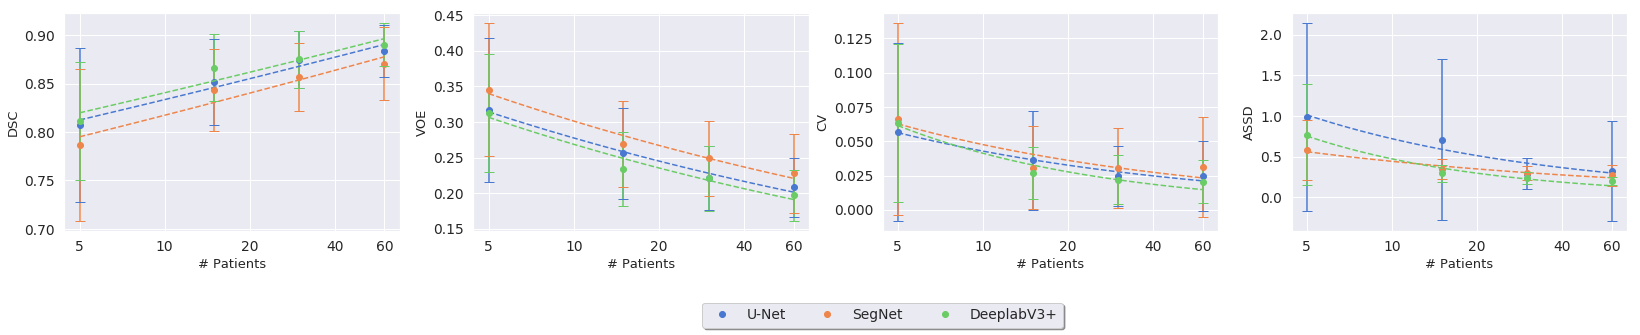

In [3]:
# Data limitation graphs
# Each architecture was run with multiple seeds
import os 

unet_data_limitation_path = '/bmrNAS/people/arjun/msk_seg_networks/data_limit_v2/%03d/unet_2d/%s/test_results'
segnet_data_limitation_path = '/bmrNAS/people/arjun/msk_seg_networks/data_limit_v2/%03d/segnet_2d/%s/test_results'
deeplab_data_limitation_path = '/bmrNAS/people/arjun/msk_seg_networks/data_limit_v2/%03d/deeplabv3_2d/%s/test_results/16_2-4-6'

dl_unet = [ # Seed 1
            [unet_data_limitation_path % (5, '2018-11-29-02-33-48'), 
             unet_data_limitation_path % (15, '2018-11-29-22-10-02'), 
             unet_data_limitation_path % (30, '2018-11-30-09-10-38'),
             unet_data_limitation_path % (60, '2018-11-30-18-33-42')],
    
            # Seed 2
            [unet_data_limitation_path % (5, '2018-11-29-02-34-10'), 
             unet_data_limitation_path % (15, '2018-11-29-21-21-16'), 
             unet_data_limitation_path % (30, '2018-11-30-07-54-29'),
             unet_data_limitation_path % (60, '2018-11-30-16-55-30')],
            
            # Seed 3
            [unet_data_limitation_path % (5, '2018-12-03-15-51-26'), 
             unet_data_limitation_path % (15, '2018-12-04-13-20-08'), 
             unet_data_limitation_path % (30, '2018-12-05-00-34-12'),
             unet_data_limitation_path % (60, '2018-12-05-19-07-13')]
           ]

dl_segnet = [   # Seed 1
                [segnet_data_limitation_path % (5, '2018-12-01-04-11-16'), 
                 segnet_data_limitation_path % (15, '2018-12-02-18-35-51'), 
                 segnet_data_limitation_path % (30, '2018-12-03-14-52-26'),
                 segnet_data_limitation_path % (60, '2018-12-04-06-28-10')],

                # Seed 2
                [segnet_data_limitation_path % (5, '2018-12-01-01-56-37'), 
                 segnet_data_limitation_path % (15, '2018-12-02-16-38-02'), 
                 segnet_data_limitation_path % (30, '2018-12-03-12-49-00'),
                 segnet_data_limitation_path % (60, '2018-12-04-04-21-46')],

                # Seed 3
                [segnet_data_limitation_path % (5, '2018-12-06-10-28-22'), 
                 segnet_data_limitation_path % (15, '2018-12-10-00-11-08'), 
                 segnet_data_limitation_path % (30, '2018-12-11-00-16-35'),
                 segnet_data_limitation_path % (60, '2018-12-11-20-08-23')]
            ]


dl_deeplab = [  # Seed 1
                [deeplab_data_limitation_path % (5, '2018-12-04-20-29-16'), 
                 deeplab_data_limitation_path % (15, '2018-12-06-04-11-52'), 
                 deeplab_data_limitation_path % (30, '2018-12-07-23-15-37'),
                 deeplab_data_limitation_path % (60, '2018-12-10-00-14-26')],

                # Seed 2
                [deeplab_data_limitation_path % (5, '2018-12-04-18-29-25'), 
                 deeplab_data_limitation_path % (15, '2018-12-06-01-36-00'), 
                 deeplab_data_limitation_path % (30, '2018-12-07-20-22-32'),
                 deeplab_data_limitation_path % (60, '2018-12-10-19-04-03')],

                # Seed 3
                [deeplab_data_limitation_path % (5, '2018-12-10-00-25-43'), 
                 deeplab_data_limitation_path % (15, '2018-12-11-08-53-04'), 
                 deeplab_data_limitation_path % (30, '2018-12-12-01-36-26'),
                 deeplab_data_limitation_path % (60, '2018-12-12-16-39-41')]
              ]

data = {'filename': 'data_limitation_v2', 'keys': ['U-Net', 'SegNet', 'DeeplabV3+'], 
        'U-Net': dl_unet, 'SegNet': dl_segnet, 'DeeplabV3+': dl_deeplab}


ov_data = {'dsc': data,
          'voe': data,
          'cv': data,
          'assd': data}

graph_data_limitation_v2(ov_data, 'data_limitation')

In [4]:
# b values for Dice
def info_per_seed(seed, param='dsc'):
    print('=======SEED %d=======' % (seed+1))
    data = {'filename': 'data_limitation', 'keys': ['U-Net', 'SegNet', 'DeeplabV3+'], 
            'U-Net': [dl_unet[seed]], 'SegNet': [dl_segnet[seed]], 'DeeplabV3+': [dl_deeplab[seed]]}

    res = get_data_limitation(data, param)

    xs, ys, SEs, x_sim, y_sim, r2, a1, b1 = res['U-Net']
    xs, ys, SEs, x_sim, y_sim, r2, a2, b2 = res['SegNet']
    xs, ys, SEs, x_sim, y_sim, r2, a3, b3 = res['DeeplabV3+']
    
    return [a1, a2, a3], [b1, b2, b3]

In [5]:
# Calculate average values for dice
As = []
Bs = []

a, b = info_per_seed(0, 'dsc')
As.append(a); Bs.append(b)

a, b = info_per_seed(1, 'dsc')
As.append(a); Bs.append(b)

a, b = info_per_seed(2, 'dsc')
As.append(a); Bs.append(b)

As = pd.DataFrame(np.asarray(As), columns=['U-Net', 'SegNet', 'DeeplabV3+'], index=['Seed %d' % seed for seed in range(1,4)])
display(pyss.kruskal_wallis(data=As, posthoc_test='dunn', p_adjust='bonferroni')['dunn'])

Bs = pd.DataFrame(np.asarray(Bs), columns=['U-Net', 'SegNet', 'DeeplabV3+'], index=['Seed %d' % seed for seed in range(1,4)])
display(pyss.kruskal_wallis(data=Bs, posthoc_test='dunn', p_adjust='bonferroni')['dunn'])

display(As.mean(axis=0))
display(Bs)

=======SEED 1=======
[0.76668946 0.03633807]
[0.70501582 0.05366225]
[0.80384287 0.02519781]
=======SEED 2=======
[0.75103178 0.04230474]
[0.78965691 0.02667987]
[0.8109862  0.02270353]
=======SEED 3=======
[0.77947537 0.03191425]
[0.74400619 0.03930639]
[0.70987696 0.06008351]


,Seed 1,Seed 2,Seed 3
Seed 1,-1.0,1.000000,1.000000
Seed 2,1.0,-1.000000,0.539137
Seed 3,1.0,0.539137,-1.000000


,Seed 1,Seed 2,Seed 3
Seed 1,-1.0,1.000000,1.000000
Seed 2,1.0,-1.000000,0.699114
Seed 3,1.0,0.699114,-1.000000


U-Net         0.765732
SegNet        0.746226
DeeplabV3+    0.774902
dtype: float64

,U-Net,SegNet,DeeplabV3+
Seed 1,0.036338,0.053662,0.025198
Seed 2,0.042305,0.026680,0.022704
Seed 3,0.031914,0.039306,0.060084


In [6]:
alpha_fit = []
beta_fit = []
metrics_names = ['dsc', 'voe', 'cv', 'assd']
for metric in metrics_names:
    As = []
    Bs = []
    for seed in range(3):
        a, b = info_per_seed(seed, metric)
        As.append(a); Bs.append(b)
    As = pd.DataFrame(np.asarray(As), columns=['U-Net', 'SegNet', 'DeeplabV3+'], index=['Seed %d' % seed for seed in range(1,4)])
    Bs = pd.DataFrame(np.asarray(Bs), columns=['U-Net', 'SegNet', 'DeeplabV3+'], index=['Seed %d' % seed for seed in range(1,4)])
    alpha_fit.append(As.mean().values)
    beta_fit.append(Bs.mean().values)
    
alpha_fit = pd.DataFrame(alpha_fit, index=metrics_names, columns=['U-Net', 'SegNet', 'DeeplabV3+'])
beta_fit = pd.DataFrame(beta_fit, index=metrics_names, columns=['U-Net', 'SegNet', 'DeeplabV3+'])

alpha_fit.style.format("{:.3}")
beta_fit.style.format("{:.3}")
display(alpha_fit)
display(beta_fit)

=======SEED 1=======
[0.76668946 0.03633807]
[0.70501582 0.05366225]
[0.80384287 0.02519781]
=======SEED 2=======
[0.75103178 0.04230474]
[0.78965691 0.02667987]
[0.8109862  0.02270353]
=======SEED 3=======
[0.77947537 0.03191425]
[0.74400619 0.03930639]
[0.70987696 0.06008351]
=======SEED 1=======
[ 0.41220891 -0.17316389]
[ 0.53612953 -0.21539457]
[ 0.35009937 -0.13953973]
=======SEED 2=======
[ 0.45381327 -0.20272647]
[ 0.37303895 -0.13557192]
[ 0.33591544 -0.12715438]
=======SEED 3=======
[ 0.39284075 -0.16033319]
[ 0.44404764 -0.16419017]
[ 0.59550344 -0.29744195]
=======SEED 1=======
[ 0.13701466 -0.44020575]
[ 0.16754202 -0.45926654]
[ 0.07170196 -0.33599484]
=======SEED 2=======
[ 0.14149284 -0.49670674]
[ 0.04535149 -0.1667619 ]
[ 0.04684622 -0.20352866]
=======SEED 3=======
[ 0.05284631 -0.20455445]
[ 0.16281769 -0.49008001]
[ 0.59856884 -1.04259857]
=======SEED 1=======
[ 1.728647   -0.34991642]
[ 1.10351762 -0.36825532]
[ 0.59535093 -0.26668939]
=======SEED 2=======
[ 5.090

,U-Net,SegNet,DeeplabV3+
dsc,0.765732,0.746226,0.774902
voe,0.419621,0.451072,0.427173
cv,0.110451,0.125237,0.239039
assd,2.700440,0.974097,4.248463


,U-Net,SegNet,DeeplabV3+
dsc,0.036852,0.039883,0.035995
voe,-0.178741,-0.171719,-0.188045
cv,-0.380489,-0.372036,-0.527374
assd,-0.503871,-0.340028,-0.589446


In [7]:
# calculate % of performance achieved by 6 patients compared to 60 (dice accuracy)
xs = np.linspace(5, 60, num=200)

unet_alpha, unet_beta = (0.76595627, 0.03672882)
segnet_alpha, segnet_beta = (0.74581177, 0.03975717)
dl_alpha, dl_beta = (0.77377658, 0.03592648)

pl_fit = lambda x, alpha, beta: alpha * x**beta

print('%s - %0.5f' % ('U-Net', pl_fit(6, unet_alpha, unet_beta) / pl_fit(60, unet_alpha, unet_beta)))
print('%s - %0.5f' % ('SegNet', pl_fit(6, segnet_alpha, segnet_beta) / pl_fit(60, segnet_alpha, segnet_beta)))
print('%s - %0.5f' % ('DeeplabV3+', pl_fit(6, dl_alpha, dl_beta) / pl_fit(60, dl_alpha, dl_beta)))
print('')

inv_fit = lambda y, alpha, beta: (y/alpha) ** (1/beta)
print('%s 95- %0.5f' % ('U-Net', inv_fit(0.95, unet_alpha, unet_beta)))
print('%s 95- %0.5f' % ('SegNet', inv_fit(0.95, segnet_alpha, segnet_beta)))
print('%s 95 - %0.5f' % ('DeeplabV3+', inv_fit(0.95, dl_alpha, dl_beta)))
print('')
print('%s 99- %0.5f' % ('U-Net', inv_fit(0.99, unet_alpha, unet_beta)))
print('%s 99- %0.5f' % ('SegNet', inv_fit(0.99, segnet_alpha, segnet_beta)))
print('%s 99 - %0.5f' % ('DeeplabV3+', inv_fit(0.99, dl_alpha, dl_beta)))
print('')

per_dsc = [pl_fit(xs, unet_alpha, unet_beta)/ pl_fit(60, unet_alpha, unet_beta) * 100,
          pl_fit(xs, segnet_alpha, segnet_beta)/ pl_fit(60, segnet_alpha, segnet_beta) * 100,
          pl_fit(xs, dl_alpha, dl_beta)/ pl_fit(60, dl_alpha, dl_beta) * 100]

U-Net - 0.91891
SegNet - 0.91252
DeeplabV3+ - 0.92061

U-Net 95- 351.73799
SegNet 95- 439.95349
DeeplabV3+ 95 - 302.19565

U-Net 99- 1081.16138
SegNet 99- 1241.45656
DeeplabV3+ 99 - 952.46829



In [8]:
# calculate % of performance achieved by 6 patients compared to 60 (VOE)
unet_alpha, unet_beta = (0.41844145, -0.17832071)
segnet_alpha, segnet_beta = (0.449181, -0.17335555)
dl_alpha, dl_beta = (0.41627207, -0.19011812)

pl_fit = lambda x, alpha, beta: alpha * x**beta

print('%s - %0.5f' % ('U-Net', (1-pl_fit(6, unet_alpha, unet_beta)) / (1-pl_fit(60, unet_alpha, unet_beta))))
print('%s - %0.5f' % ('SegNet', (1-pl_fit(6, segnet_alpha, segnet_beta)) / (1-pl_fit(60, segnet_alpha, segnet_beta))))
print('%s - %0.5f' % ('DeeplabV3+', (1-pl_fit(6, dl_alpha, dl_beta)) / (1-pl_fit(60, dl_alpha, dl_beta))))

per_voe = [pl_fit(xs, unet_alpha, unet_beta)/ pl_fit(60, unet_alpha, unet_beta) * 100,
          pl_fit(xs, segnet_alpha, segnet_beta)/ pl_fit(60, segnet_alpha, segnet_beta) * 100,
          pl_fit(xs, dl_alpha, dl_beta)/ pl_fit(60, dl_alpha, dl_beta) * 100]

U-Net - 0.87177
SegNet - 0.86092
DeeplabV3+ - 0.87022


In [9]:
# calculate % of performance achieved by 6 patients compared to 60 (CV)
unet_alpha, unet_beta = (0.10516422, -0.39126001)
segnet_alpha, segnet_beta = (0.11894699, -0.39801299)
dl_alpha, dl_beta = (0.15475838, -0.5740492)

pl_fit = lambda x, alpha, beta: alpha * x**beta

print('%s - %0.5f' % ('U-Net', (1-pl_fit(6, unet_alpha, unet_beta)) / (1-pl_fit(60, unet_alpha, unet_beta))))
print('%s - %0.5f' % ('SegNet', (1-pl_fit(6, segnet_alpha, segnet_beta)) / (1-pl_fit(60, segnet_alpha, segnet_beta))))
print('%s - %0.5f' % ('Deeplabv3+', (1-pl_fit(6, dl_alpha, dl_beta)) / (1-pl_fit(60, dl_alpha, dl_beta))))

per_cv = [pl_fit(xs, unet_alpha, unet_beta)/ pl_fit(60, unet_alpha, unet_beta) * 100,
          pl_fit(xs, segnet_alpha, segnet_beta)/ pl_fit(60, segnet_alpha, segnet_beta) * 100,
          pl_fit(xs, dl_alpha, dl_beta)/ pl_fit(60, dl_alpha, dl_beta) * 100]

U-Net - 0.96835
SegNet - 0.96418
Deeplabv3+ - 0.95882


## Training Profiles

In [10]:
# Initialize data filepaths
from copy import deepcopy
data_filepaths = {'U-Net': deepcopy(dl_unet), 'SegNet': deepcopy(dl_segnet), 'DeeplabV3+': deepcopy(dl_deeplab)}
for network in data_filepaths.keys():
    fps = data_filepaths[network]
    for i in range(len(fps)):
        for j in range(len(fps[i])):
            s_ind = fps[i][j].find('test_results')
            fps[i][j] = os.path.join(fps[i][j][:s_ind], 'pik_data.dat')
    data_filepaths[network] = np.asarray(fps)

# color -> network, linestyle -> seed
cpal = sns.color_palette("muted", 3)
lstyles = ['--', ':', '-.']

# Define function for smoothing loss
def linear_smoothing(vals, weight=0.6):
    assert weight > 0 and weight <= 1
    info = [vals[i-1]*weight + vals[i]*(1-weight) for i in range(1,len(vals))]
    a = [info[0]]
    a.extend(info)
    return a

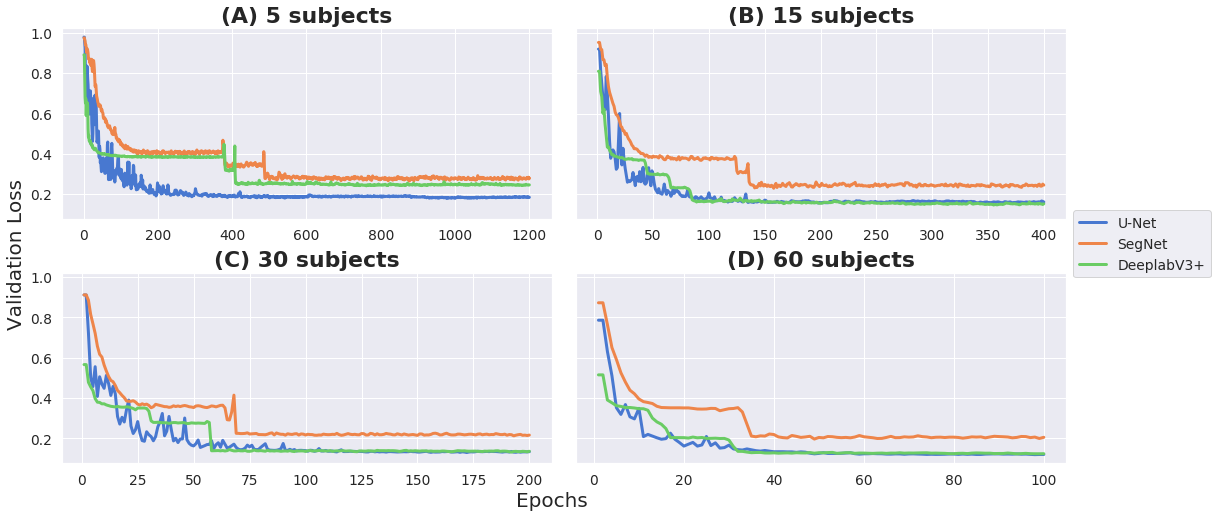

In [11]:
# Plot validation loss profile for 3 networks, averaged across different seeds
smoothing_factor = 0.8
fig, axs = plt.subplots(2, 2, sharey='all', figsize=(18, 8))
axs = axs.flatten()

networks = data_filepaths.keys()
for axs_ind, ax in enumerate(axs):
    for net_ind, network in enumerate(networks):
        fps = data_filepaths[network][:, axs_ind]
        epochs = utils.io_utils.load_pik(fps[0])[0]
        val_data = []
        for fp in fps:
            smooth_val_data = linear_smoothing(utils.io_utils.load_pik(fp)[2], smoothing_factor)
            val_data.append(smooth_val_data)
        val_loss = np.mean(np.asarray(val_data), axis=0)
        ax.plot(epochs, val_loss, color=cpal[net_ind], label=network, linewidth=3)
plt.subplots_adjust(wspace=0.05, hspace=0.28)
axs[2].set_ylabel('Validation Loss', y=1.1, fontsize=20)
ax = axs[-1]
ax.set_xlabel('Epochs', fontsize=20, x=-0.05)
#ax.legend(loc='upper center', bbox_to_anchor=(0, -0.22), ncol=len(networks))
ax.legend(loc='center left', bbox_to_anchor=(1, 1.15))
for ds_ind, ds in enumerate(['(A) 5', '(B) 15', '(C) 30', '(D) 60']):
    axs[ds_ind].set_title('%s subjects' % ds, fontsize=22, fontweight='bold')
plt.savefig('/bmrNAS/people/arjun/msk_seg_networks/analysis/data-limit-val-loss.png', dpi=800, bbox_to_inches='tight')

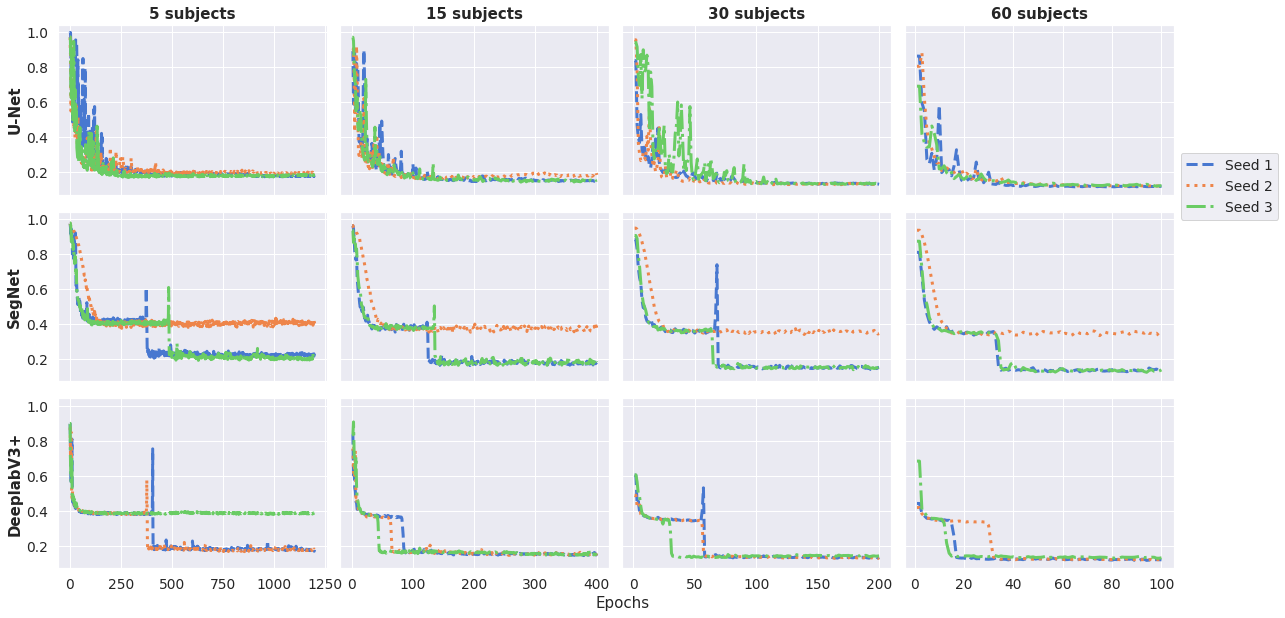

In [12]:
# Plot validation loss profile for 3 networks, averaged across different seeds
smoothing_factor = 0.8
num_points = 100
networks = data_filepaths.keys()
fig, axs = plt.subplots(len(networks), 4, sharey='all', sharex='col', figsize=(20, 10))

for net_ind, network in enumerate(networks):
    for ds_ind, data_size in enumerate([5, 15, 30, 60]):
        fps = data_filepaths[network][:, ds_ind]
        epochs = utils.io_utils.load_pik(fps[0])[0]
        for fp_ind, fp in enumerate(fps):
            val_loss_smooth = linear_smoothing(utils.io_utils.load_pik(fp)[2], smoothing_factor)
            axs[net_ind][ds_ind].plot(epochs, val_loss_smooth, color=cpal[fp_ind], 
                                        linestyle=lstyles[fp_ind],
                                        label='Seed %d' % (fp_ind+1), 
                                        linewidth=3)
        axs[net_ind][0].set_ylabel(network, fontsize=15, fontweight='bold')
        axs[0][ds_ind].set_title('%d subjects' % data_size, fontsize=15, fontweight='bold')
plt.subplots_adjust(wspace=0.05, hspace=0.1)

axs[-1][2].set_xlabel('Epochs', x=0)
axs[1][-1].legend(loc='center left', bbox_to_anchor=(1, 1.15))